In [1]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import requests
import json
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
pods_mean_vec = pd.read_pickle("pods_mean_vec.pkl")
pod_ids = pd.read_pickle("pod_descriptions.pkl")
pods_mean_vec.reset_index(drop=True, inplace=True)
pods_mean_vec = pods_mean_vec.merge(pod_ids)

In [3]:
pods_mean_vec = pods_mean_vec.sort_values(by = ["genre", "subgenre"]).reset_index(drop = True)

In [4]:
vecs = pods_mean_vec['vector'].to_numpy()
vecs = np.array([vec for vec in vecs])

In [5]:
sims = cosine_similarity(vecs)

In [7]:
tsne = TSNE(n_components=2, perplexity=30, n_jobs = -1, verbose = 1)
X_tsne = tsne.fit_transform(vecs)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 19715 samples in 1.000s...
[t-SNE] Computed neighbors for 19715 samples in 60.111s...
[t-SNE] Computed conditional probabilities for sample 1000 / 19715
[t-SNE] Computed conditional probabilities for sample 2000 / 19715
[t-SNE] Computed conditional probabilities for sample 3000 / 19715
[t-SNE] Computed conditional probabilities for sample 4000 / 19715
[t-SNE] Computed conditional probabilities for sample 5000 / 19715
[t-SNE] Computed conditional probabilities for sample 6000 / 19715
[t-SNE] Computed conditional probabilities for sample 7000 / 19715
[t-SNE] Computed conditional probabilities for sample 8000 / 19715
[t-SNE] Computed conditional probabilities for sample 9000 / 19715
[t-SNE] Computed conditional probabilities for sample 10000 / 19715
[t-SNE] Computed conditional probabilities for sample 11000 / 19715
[t-SNE] Computed conditional probabilities for sample 12000 / 19715
[t-SNE] Computed conditional probabilities for sa

In [8]:
pod_groups = pod_ids.groupby(by = "subgenre").groups
subgenres = list(pod_groups.keys())
pod_groups = pod_ids.groupby(by = "genre").groups
genres = list(pod_groups.keys())
genre_mapping = {g:i for i, g in enumerate(genres)}
subgenre_mapping = {g:i for i, g in enumerate(subgenres)}
colors_genres = np.arange(len(genres))
colors_subgenres = np.arange(len(subgenres))
c_genres = [colors_genres[p] for p in pods_mean_vec["genre"].apply(lambda x: genre_mapping[x])]
c_subgenres = [colors_subgenres[p]%10 for p in pods_mean_vec["subgenre"].apply(lambda x: subgenre_mapping[x])]

In [58]:
def search_pod(key_word):
    itunesUrl = 'https://itunes.apple.com/search?'
    parameters = {}
    parameters['entity'] = 'podcast'
    parameters['attribute'] = 'titleTerm'

    requestString = ''
    for param in parameters:
        paramString = param + '=' + parameters[param]
        if len(requestString) == 0:
            requestString = paramString
        else:
            requestString = requestString + '&' + paramString

    itunesUrl = itunesUrl + requestString + '&term='
    testUrl = itunesUrl + key_word
    r = requests.get(testUrl)
    res = json.loads(r.text)['results']
    return [r['collectionId'] for r in res], [r['collectionName'] for r in res]

In [59]:
search_term = "my favorite murder"
ids, _titles = search_pod(search_term)
idxs = []
titles = []
for _id, _title in zip(ids, _titles):
    try:
        pod_index = pods_mean_vec[pods_mean_vec["itunes_id"] == _id].index[0]
        idxs.append(pod_index)
        titles.append(_title)
    except:
        pass
print(titles[:5])

['My Favorite Murder with Karen Kilgariff and Georgia Hardstark']


In [60]:
choice = 0
idx = np.argsort(sims[idxs[choice]])[::-1][:100]

In [63]:
idxs[choice]

19505

In [ ]:
pods_mean_vec

In [ ]:
idx = np.argsort(sims[np.random.randint(sims.shape[0])])[::-1][:20]

Ross Tucker Football Podcast: NFL Podcast  |  Sports  |  Sports


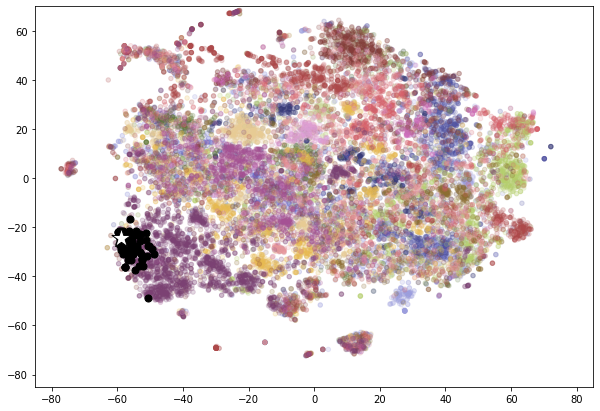

,titles,descriptions,genre,subgenre
17414,Ross Tucker Football Podcast: NFL Podcast,Follow Ross on Twitter @RossTuckerNFL & @RossT...,Sports,Sports
17423,Fantasy Feast: NFL Fantasy Football Podcast,Former NFL player Ross Tucker (@RossTuckerNFL)...,Sports,Sports
16238,The PFF NFL Podcast,Steve Palazzolo and Sam Monson bring you an NF...,Sports,Football
16253,NFL Live,ESPN's NFL Live scoops the latest news and inf...,Sports,Football
15762,SportsTalk on TribLIVE.com Podcast,Listen in 9-5 Monday through Friday for the la...,Sports,Basketball
16101,QB List Fantasy Football,Fantasy Football Podcasts from QB List,Sports,Fantasy Sports
15793,WNML All Audio Main Channel,Every one of our podcasts on every feed is com...,Sports,Basketball
17465,VSiN Best Bets,"Daily sports betting highlights from VSiN, The...",Sports,Sports
16026,The Most Accurate Podcast,"4for4 Fantasy Football's John Paulsen, Anthony...",Sports,Fantasy Sports
16226,Behind the Bets with Doug Kezirian,ESPN gambling analyst Doug Kezirian and his ca...,Sports,Football


In [49]:
%matplotlib inline
pod_idx = np.random.randint(sims.shape[0])
# 4138
idx = np.argsort(sims[pod_idx])[::-1][:100]
# idx = np.argsort(sims[4212])[::-1][:100]
print(pods_mean_vec.loc[pod_idx, "titles"], " | ",
     pods_mean_vec.loc[pod_idx, "genre"], " | ",
     pods_mean_vec.loc[pod_idx, "subgenre"])

figure, ax = plt.subplots(figsize=(10,7))
ax.set_xlim([-85, 85])
ax.set_ylim([-85, 70])
ax.scatter(X_tsne[:,0], X_tsne[:,1], s = 20, alpha= 0.2, c = c_genres, cmap = 'tab20b')
ax.scatter(X_tsne[idx,0], X_tsne[idx,1], s = 50, alpha = 1, c = 'k') #[c_genres[i] for i in idx])
ax.scatter(X_tsne[idx[0],0], X_tsne[idx[0],1], s = 400, c = 'w', edgecolors = 'k', marker = "*")
plt.show()

pods_mean_vec.loc[idx,["titles", "descriptions", "genre", "subgenre"]][:10]


Arts


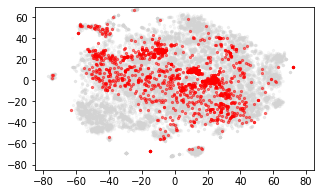

Business


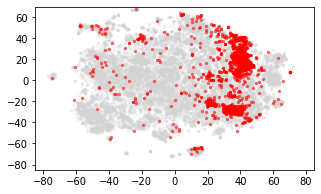

Comedy


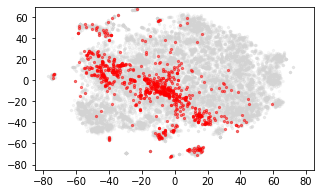

Education


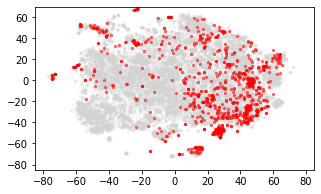

Fiction


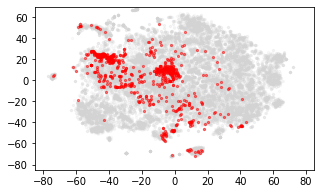

Government


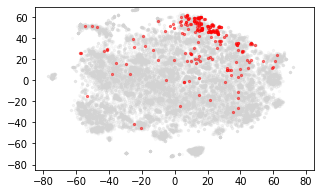

Health & Fitness


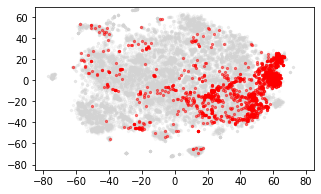

History


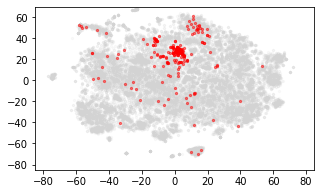

Kids & Family


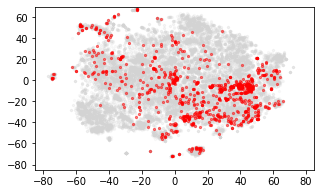

Leisure


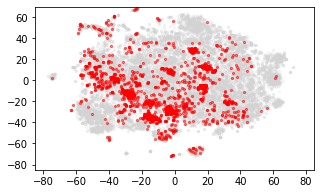

Music


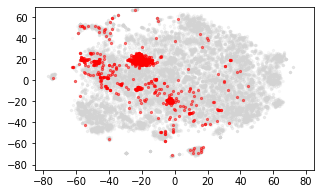

News


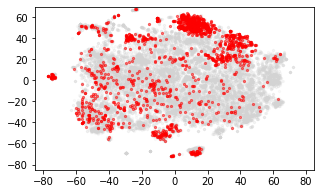

Religion & Spirituality


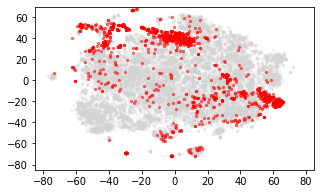

Science


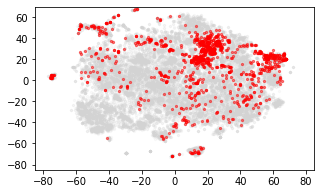

Society & Culture


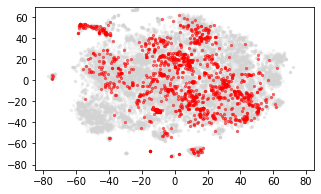

Sports


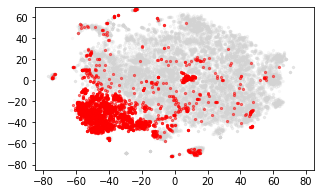

TV & Film


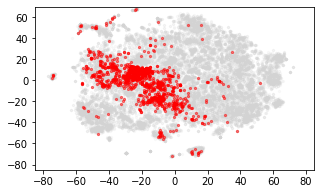

Technology


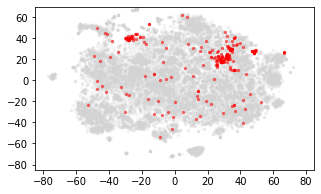

True Crime


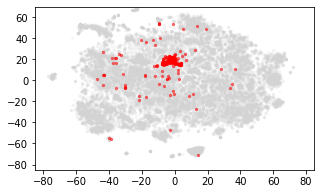

In [31]:
%matplotlib inline
for genre_id in range(19):
    genre_idxs = pods_mean_vec[pods_mean_vec["genre"] == genres[genre_id]].index

    print(genres[genre_id])
    figure, ax = plt.subplots(figsize=(5,3))
    ax.set_xlim([-85, 85])
    ax.set_ylim([-85, 70])
    ax.scatter(X_tsne[:,0], X_tsne[:,1], s = 5, alpha= 0.1, c = 'lightgray') #c_genres, cmap = 'tab20b')

    ax.scatter(X_tsne[genre_idxs,0], X_tsne[genre_idxs,1], s = 5, alpha= 0.5, c = 'r', cmap = 'tab20b')

    # ax.plot(p_x, p_y, c = 'k')
    plt.show()

My Favorite Murder with Karen Kilgariff and Georgia Hardstark  |  True Crime  |  True Crime


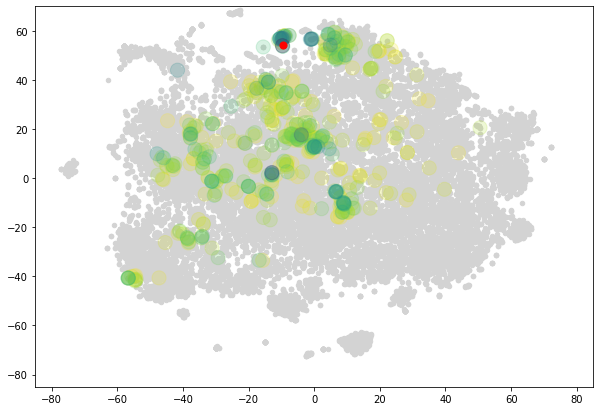

In [64]:
%matplotlib inline
pod_idx = 19505
# pod_idx = np.random.randint(sims.shape[0])
# pod_idx = 10549
idx = np.argsort(sims[pod_idx])[-500:-1]#[::-1][1:10000][::-1]
print(pods_mean_vec.loc[pod_idx,"titles"], ' | ', pods_mean_vec.loc[pod_idx,"genre"],
     " | ", pods_mean_vec.loc[pod_idx,"subgenre"])
c = sims[pod_idx][idx]

figure, ax = plt.subplots(figsize=(10,7))
ax.set_xlim([-85, 85])
ax.set_ylim([-85, 70])
ax.scatter(X_tsne[:,0], X_tsne[:,1], s = 20, c = 'lightgray')
ax.scatter(X_tsne[idx,0], X_tsne[idx,1], alpha = 0.2, s = 200, c = -c, cmap = "viridis")
ax.scatter(X_tsne[pod_idx,0], X_tsne[pod_idx,1], s = 50, c = 'r', marker = "o")
plt.show()

# pods_mean_vec.loc[idx][:20]


In [65]:
pods_mean_vec[["titles", "descriptions","genre","subgenre"]].loc[idx][-20:][::-1]

,titles,descriptions,genre,subgenre
19677,Dark Topic,Host Jack Luna covers the worlds darkest stori...,True Crime,True Crime
2809,Hollywood Crime Scene,Desi Jedeikin and Rachel Fisher tell true tale...,Comedy,Comedy
19618,Jensen and Holes: The Murder Squad,Retired Cold Case Investigator Paul Holes and ...,True Crime,True Crime
10471,Down in Alabama with Ike Morgan,Alabama news updates.,News,Daily News
14452,The Distance: Coronavirus Dispatches,"The Distance features short, first-person stor...",Society & Culture,Documentary
11405,The Ticket Daily Dump,The Ticket Daily Dump is warm and fresh newly ...,News,Sports News
10743,From Ha Ha's to Aha's,From HaHa’s to Aha’s is a podcast brought to y...,News,Entertainment News
10528,The Wake Up,Hear the latest weekday news and headlines fro...,News,Daily News
10543,News Updates from The Oregonian,A rundown of the day's top Portland and Oregon...,News,Daily News
501,Vogue Style Revolution,A weekly podcast that explores the upending fo...,Arts,Fashion & Beauty
